<h1>Generalized Autoregressive with Exogeneous Input Data Simulation</h1>

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
%matplotlib inline


In [73]:
x = np.ones(4)

In [74]:
x

array([1., 1., 1., 1.])

In [89]:
np.zeros(4)+0.001

array([0.001, 0.001, 0.001, 0.001])

In [2]:
# Construct the model
class ARXm(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, order, x_t):
        # Initialize the state space model
        super(ARXm, self).__init__(endog, exog = x_t, k_states=order+1, 
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        test = exog[np.newaxis, np.newaxis, :]
        zero = np.zeros([1,1,len(exog)])
        one = np.ones([1,1,len(exog)])
        con_design = np.concatenate((one,zero,zero,test), axis = 1)
        
        self.ssm["design"] = con_design  # shaped 1 x order+1 x nobs
        #self.ssm["selection"] = np.zeros(self.k_states)
        self.ssm["selection"] = np.eye(self.k_states)
        self.ssm["selection", 1, 1] = 0
        self.ssm["selection", 2, 2] = 0
        self.ssm["transition"] = np.eye(self.k_states, k = 1)
        self.ssm["transition", 2, 3] = 0
        
        
        self.positive_parameters = slice(self.k_states+1, self.k_states+3)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ARXm, self).update(params, transformed, **kwargs)

        self['transition', :self.k_states-1, 0] = params[:self.k_states-1]
        self["transition", 3, 3] = params[self.k_states-1]
        self['state_cov', 0, 0] = params[self.k_states]
        self['state_cov', 3, 3] = params[self.k_states+1]
        #self['state_cov'] = np.diag(params[self.k_states:self.k_states+4])
        

    # Specify start parameters
    @property
    def start_params(self):
        #exog = sm.add_constant(self.exog)
        #res = sm.OLS(self.endog, exog).fit()
        inte = np.zeros(self.k_states-1)+0.001
        params = np.r_[inte, 0.5, 1, 1]
        return params  # 0s don't converge; 0.15 instead (need to be improved)
    
    def transform_params(self, unconstrained):
        """
        We constraint the last parameter to be positive,
        because it is variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
       
        for i in range(self.k_states-1):
            constrained[i] = constrain_stationary_univariate(constrained[i:i+1])
       
        '''
        constrained[0] = constrain_stationary_univariate(constrained[0:1])
        constrained[1] = constrain_stationary_univariate(constrained[1:2])
        constrained[2] = constrain_stationary_univariate(constrained[2:3])
        '''
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
     
        for i in range(self.k_states-1):
            unconstrained[i] = unconstrain_stationary_univariate(constrained[i:i+1])
        return unconstrained
   
        

In [93]:
mod = ARXm(y_sim,3,x_t)
res = mod.fit()
print(res.summary())

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                           ARXm   Log Likelihood              -80928.102
Date:                Thu, 12 Jan 2023   AIC                         161868.203
Time:                        22:41:07   BIC                         161911.465
Sample:                             0   HQIC                        161882.847
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.0966      0.021      4.630      0.000       0.056       0.137
param.1        0.0639      0.018      3.558      0.000       0.029       0.099
param.2        0.1159      0.011     10.679      0.0

In [83]:
# We could fit an AR(2) model, described above
mod_ar3 = sm.tsa.SARIMAX(y_sim, order=(3,0,0),exog = x_t)
# Note that mod_ar2 is an instance of the SARIMAX class

# Fit the model via maximum likelihood
res_ar3 = mod_ar3.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_ar3.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -9496.527
Date:                Thu, 12 Jan 2023   AIC                          19003.053
Time:                        22:37:04   BIC                          19039.105
Sample:                             0   HQIC                         19015.257
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0137      0.007      1.834      0.067      -0.001       0.028
ar.L1          0.5089      0.008     62.122      0.000       0.493       0.525
ar.L2         -0.1920      0.010    -19.129      0.0

<li>ARX3<ol>
    <li>Phi: autoregression weight</li>
    <li>Sigma: variance of noice</li>
    </ol>
</li>
    
\begin{equation*}
{\phi}(L)y_{t} = \rho{\beta_t}u_{t} + \epsilon_t \\
y_{t} = {\phi_1}y_{t-1} + {\phi_2}y_{t-2} + {\phi_3}y_{t-3} + \rho{\beta_t}u_{t} + \
    \epsilon_t \\
(1-\sum_{1=1}^3 a_iL^i)y_t = \rho\beta_tu_{t} + \epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
n = 1 \\
\phi_1 = 0.5 \\
\phi_2 = -0.2 \\
\phi_3 = 0.3 \\
\beta_t \sim N(0,\sigma^2) \\
\sigma^2 = 1 \\
\end{equation*}
    
State Space Representation (Harvey): 

\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & 0 & ut  
\end{vmatrix} \alpha_t \\
\textrm{shaped 1 x 4 x nobs} \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & 1 & 0 & 0\\
\phi_2 & 0 & 1 & 0\\
\phi_3 & 0 & 0 & 0\\
0 & 0 & 0 & \rho_t
\end{vmatrix} \alpha_t + \mu_t \\
\mu_t = \begin{vmatrix}
\epsilon_{y,t+1}\\
0 \\
0 \\
\epsilon_{\beta,t+1}
\end{vmatrix}
\sim N(\begin{vmatrix}
0 \\
0 \\
0 \\
0
\end{vmatrix},\begin{vmatrix}
\sigma_{y,t+1} & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_{\beta,t+1}
\end{vmatrix})
\end{equation*}

\begin{equation*}
a_t = 
\begin{vmatrix}
y_{t-1} \\
\phi_2 y_{t-2} + \phi_3 y_{t-3} \\
\phi_3 y_{t-2} \\
\beta_{t}
\end{vmatrix}
\end{equation*}

In [3]:

nobs = 10000
true_rho = 1
var_beta = 1
var_y = 0.36
true_phi = np.r_[0.5, -0.2, 0.3]

np.random.seed(1234)

disturbances_beta = np.random.normal(0, var_beta ** 0.5, size=(nobs,))
disturbances_y = np.random.normal(0, var_y ** 0.5, size=(nobs,))
x_t = np.random.uniform(-1,1,nobs)
#endog = lfilter([1], np.r_[1, -true_phi], disturbances_y)
beta = np.cumsum(disturbances_beta)
#beta = lfilter([1], np.r_[1, -true_rho], disturbances_beta)
exog = beta*x_t
y_sim = lfilter([1], np.r_[1, -true_phi], exog)



In [26]:
beta[1]

-0.8915034291383486

In [27]:
x_t[1]

-0.21638809788061386

In [28]:
exog[1]

0.19291073128529188

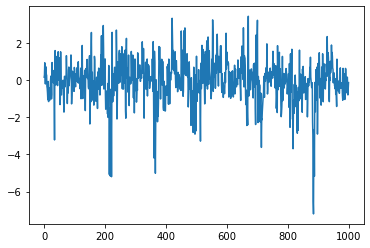

In [29]:
plt.plot(y_sim)

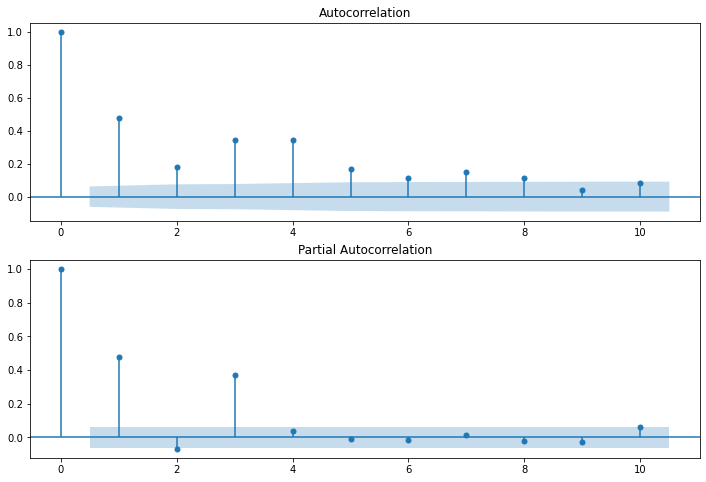

In [30]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_sim.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_sim.squeeze(), lags=10, ax=ax2)

In [4]:
mod = ARXm(y_sim,3,x_t)
res = mod.fit()
print(res.summary())

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                           ARXm   Log Likelihood              -80928.102
Date:                Fri, 13 Jan 2023   AIC                         161868.203
Time:                        08:15:45   BIC                         161911.465
Sample:                             0   HQIC                        161882.847
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.0966      0.021      4.630      0.000       0.056       0.137
param.1        0.0639      0.018      3.558      0.000       0.029       0.099
param.2        0.1159      0.011     10.679      0.0

In [19]:
res.smoothed_state[3,:]

array([ 0.03599979,  0.04514564,  0.2967444 , ..., -0.59286788,
        0.90144678,  2.35811617])

In [88]:
res.aic

2788.92092777356

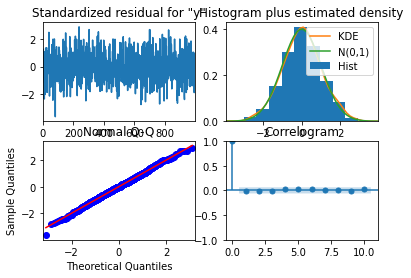

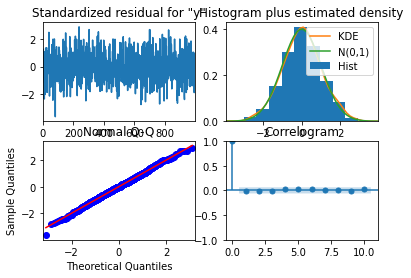

In [57]:
res.plot_diagnostics()

<h2>Jarque-Bera: [test_statistic, pvalue, skewness, kurtosis] </h2>
<h3>Goodness of fit </h3>

In [59]:
print(res.test_normality(method='jarquebera'))

[[ 0.23753265  0.88801528 -0.03460114  3.03019648]]


<h2>Goldfeld-Quandt type test: [test_statistic, pvalue] </h2>
<h3>Heteroskedasticity </h3>

In [61]:
print(res.test_heteroskedasticity(method='breakvar'))

[[1.05587354 0.62013254]]


<h2>Ljung-Box test: [test_statistic, pvalue] for each lag (overlap with plot_diagnostics)</h2> 
<h3>residuals from the ARIMA model have autocorrelation or not</h3>

In [62]:
print(res.test_serial_correlation(method='ljungbox'))

[[[0.12512417 0.18073023 0.43468683 0.77958307 2.0902451  3.05122921
   3.05166113 3.1722692  3.39787321 3.74236522]
  [0.72354202 0.91359756 0.93298738 0.94116409 0.83652229 0.80239011
   0.88018236 0.92308594 0.9464146  0.95822181]]]


/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<h2>AIC plot</h2>

In [92]:
orders = 7
AIC_df = pd.DataFrame()
for order in range(1,orders):
    mod = ARm(endogm,order)
    res = mod.fit()
    aic = res.aic
    temp = pd.DataFrame({'ar': [order],\
                            'aic': [aic]})
        
    AIC_df = AIC_df.append(temp)

<AxesSubplot:xlabel='ar', ylabel='aic'>

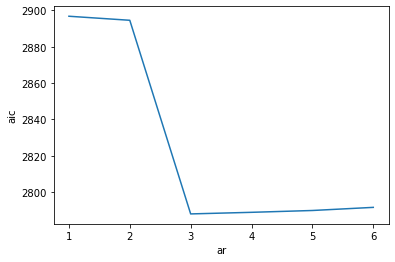

In [94]:
sns.lineplot(data = AIC_df, x = 'ar', y = 'aic')